In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Load data
base_path = "/home/tvanhout/oxides_ML/models/test_training"
directory = "test"

df_training     = pd.read_csv(os.path.join(base_path, directory , "training.csv"))
df_train_set    = pd.read_csv(os.path.join(base_path, directory , "train_set.csv")) 
df_test_set     = pd.read_csv(os.path.join(base_path, directory , "test_set.csv"))
df_val_set      = pd.read_csv(os.path.join(base_path, directory , "validation_set.csv"))
df_uq           = pd.read_csv(os.path.join(base_path, directory , "uq.csv"))

df_test_set[["Abs_error_eV"]].mean()

Abs_error_eV    0.412875
dtype: float64

## Performance metrics

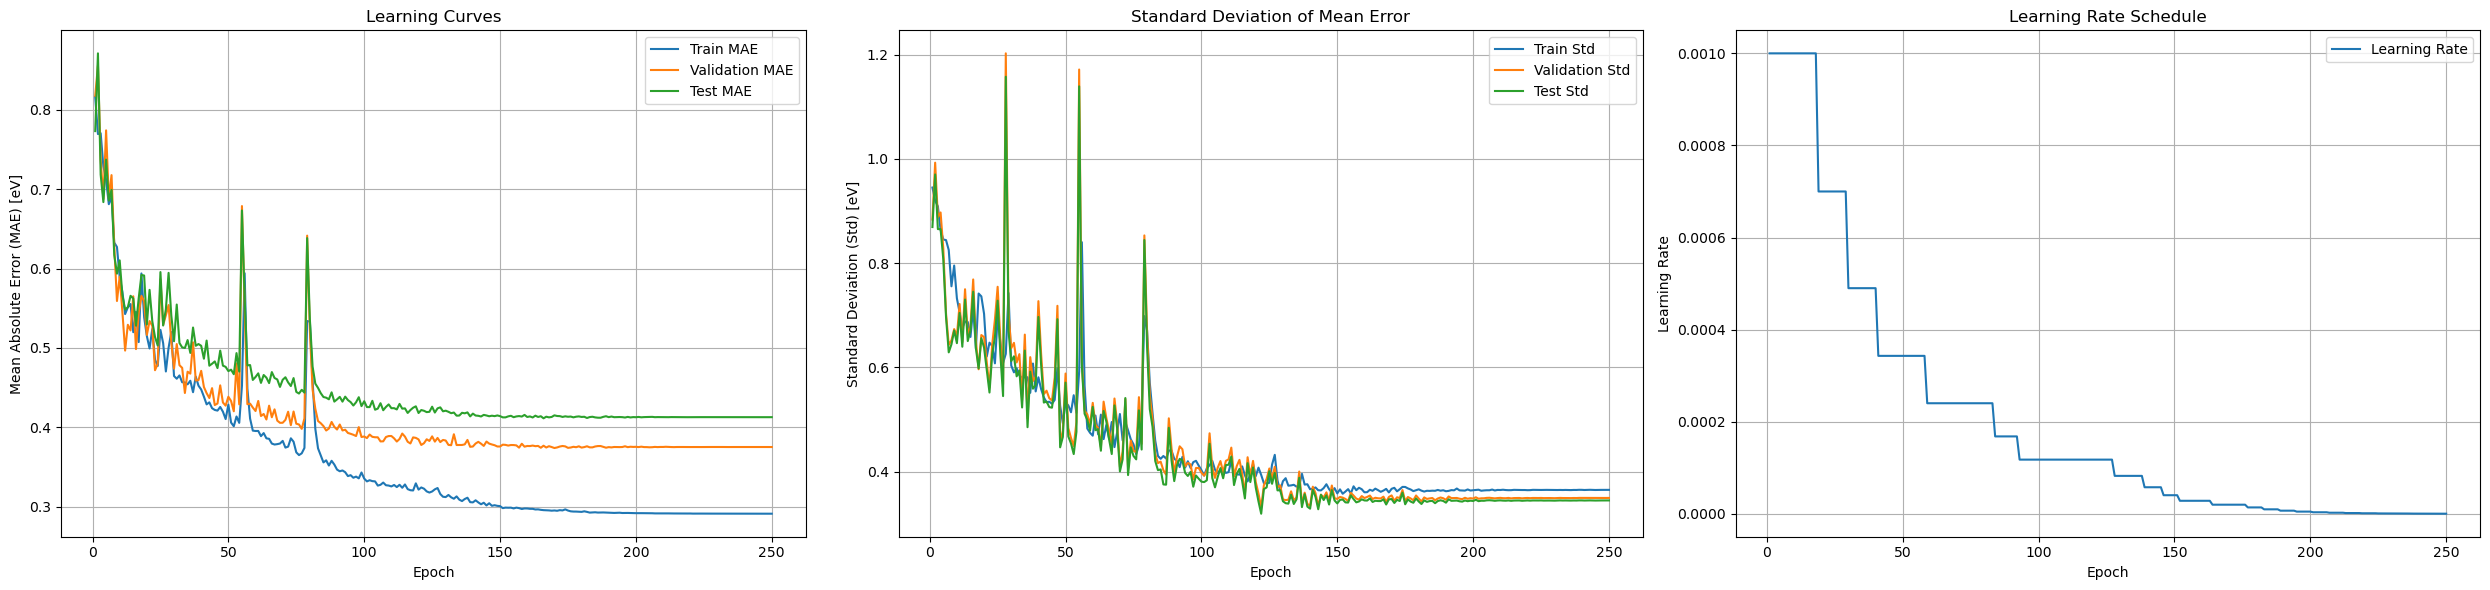

In [2]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Learning Curves (Train, Val, Test MAE)
axs[0].plot(df_training['Epoch'], df_training['Train_MAE_eV'], label='Train MAE')
axs[0].plot(df_training['Epoch'], df_training['Val_MAE_eV'], label='Validation MAE')
axs[0].plot(df_training['Epoch'], df_training['Test_MAE_eV'], label='Test MAE')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error (MAE) [eV]')
axs[0].set_title('Learning Curves')
axs[0].legend()
axs[0].grid(True)

# Standard Deviation of Predictions (Train, Val, Test Std)
axs[1].plot(df_training['Epoch'], df_training['Train_std_eV'], label='Train Std')
axs[1].plot(df_training['Epoch'], df_training['Val_std_eV'], label='Validation Std')
axs[1].plot(df_training['Epoch'], df_training['Test_std_eV'], label='Test Std')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Standard Deviation (Std) [eV]')
axs[1].set_title('Standard Deviation of Mean Error')
axs[1].legend()
axs[1].grid(True)

# Learning Rate Schedule
axs[2].plot(df_training['Epoch'], df_training['Learning_Rate'], label='Learning Rate')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


##  Evaluation of the test set

/tmp/ipykernel_3812037/880315723.py:6: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Material", style = "State", s=100, palette= palette, ax=axes[0])


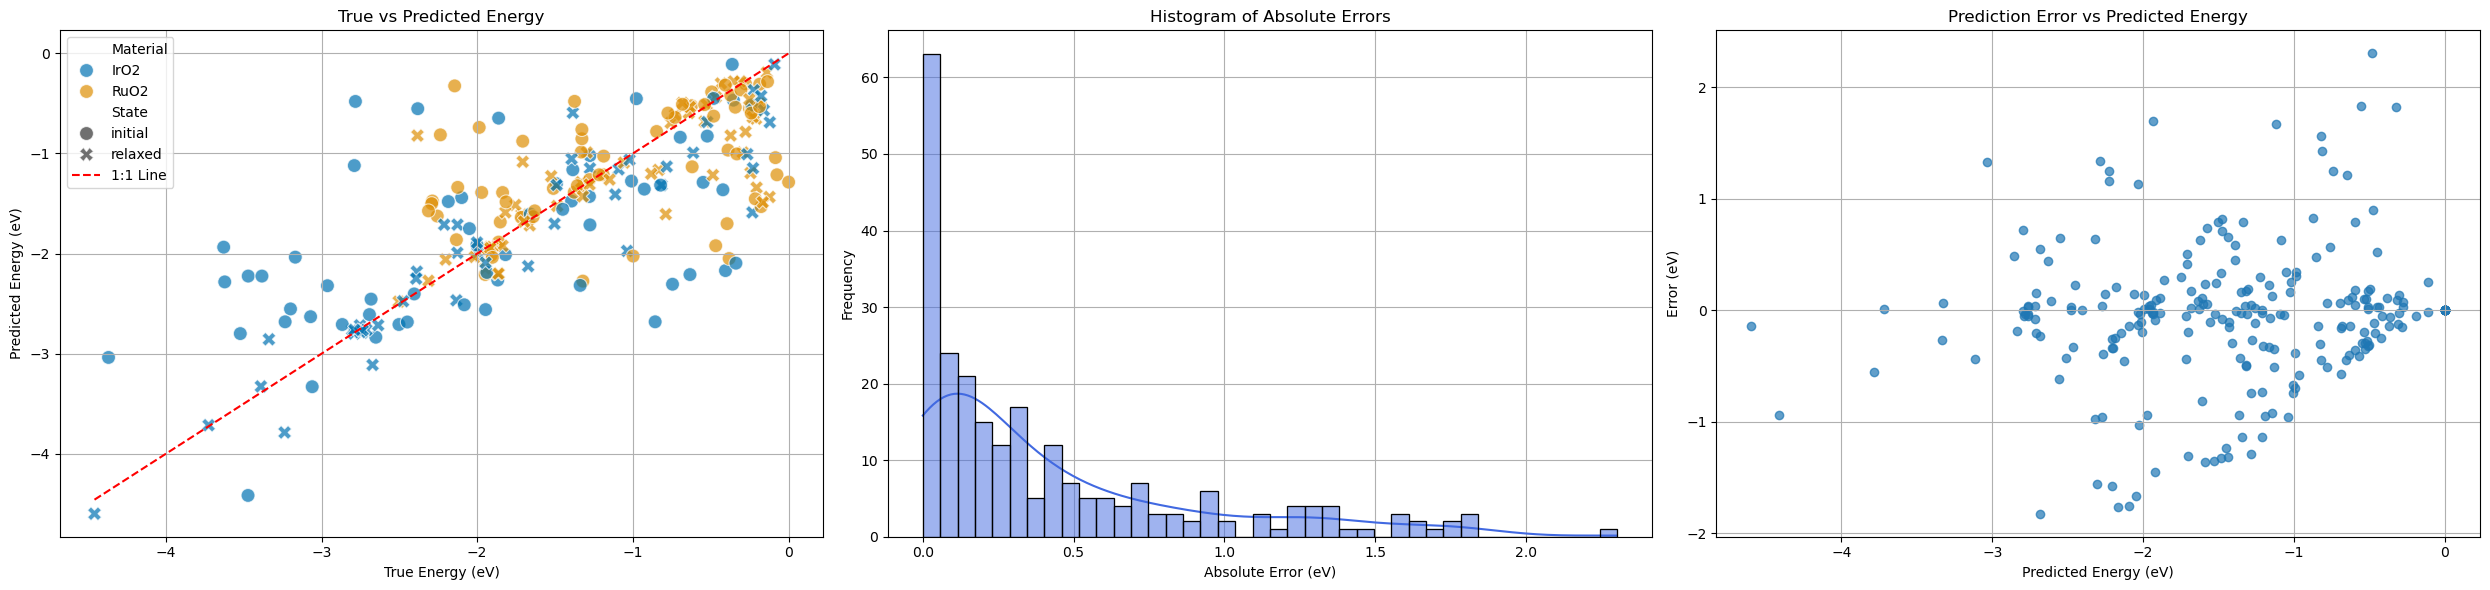

In [18]:
palette = sns.color_palette("colorblind")

fig, axes = plt.subplots(1, 3, figsize=(25, 6))  

# True vs. Predicted Energy Plot
sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Material", style = "State", s=100, palette= palette, ax=axes[0])
axes[0].plot([min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             [min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             'r--', label='1:1 Line')
axes[0].set_xlabel('True Energy (eV)')
axes[0].set_ylabel('Predicted Energy (eV)')
axes[0].set_title('True vs Predicted Energy')
axes[0].legend()
axes[0].grid(True)

# Histogram of Absolute Errors
sns.histplot(df_test_set['Abs_error_eV'], bins=40, kde=True, color='royalblue', ax=axes[1], zorder = 10)
axes[1].set_xlabel('Absolute Error (eV)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Absolute Errors')
axes[1].grid(True)

# Prediction Error vs. Predicted Energy
axes[2].scatter(df_test_set['Prediction_eV'], df_test_set['Error_eV'], alpha=0.7)
axes[2].set_xlabel('Predicted Energy (eV)')
axes[2].set_ylabel('Error (eV)')
axes[2].set_title('Prediction Error vs Predicted Energy')
axes[2].grid(True)

plt.tight_layout()
plt.show()


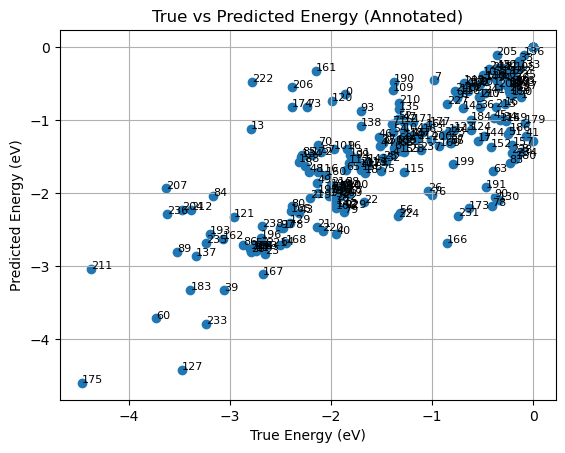

In [4]:
# Identify points of interest (e.g., large negative error)
outliers = (df_test_set['True_eV'] < -0) & (df_test_set['Prediction_eV'] < -0)

# Use the mask to filter the actual rows
outlier_rows = df_test_set[outliers]

fig, ax = plt.subplots()
scatter = ax.scatter(df_test_set["True_eV"], df_test_set["Prediction_eV"])

# Annotate interesting points
for i, row in outlier_rows.iterrows():
    ax.annotate(f"{i}", (row["True_eV"], row["Prediction_eV"]), fontsize=8)

plt.xlabel("True Energy (eV)")
plt.ylabel("Predicted Energy (eV)")
plt.title("True vs Predicted Energy (Annotated)")
plt.grid(True)
plt.show()

In [5]:
entry = df_test_set.iloc[207]
entry

System            CH3Ir40NO81
Material                 IrO2
Surface                 110.0
Molecule Group         amides
Molecule            Formamide
State                 initial
True_eV             -3.628155
Prediction_eV       -1.935792
Error_eV             1.692364
Abs_error_eV         1.692364
Name: 207, dtype: object

## Uncertainty quantification

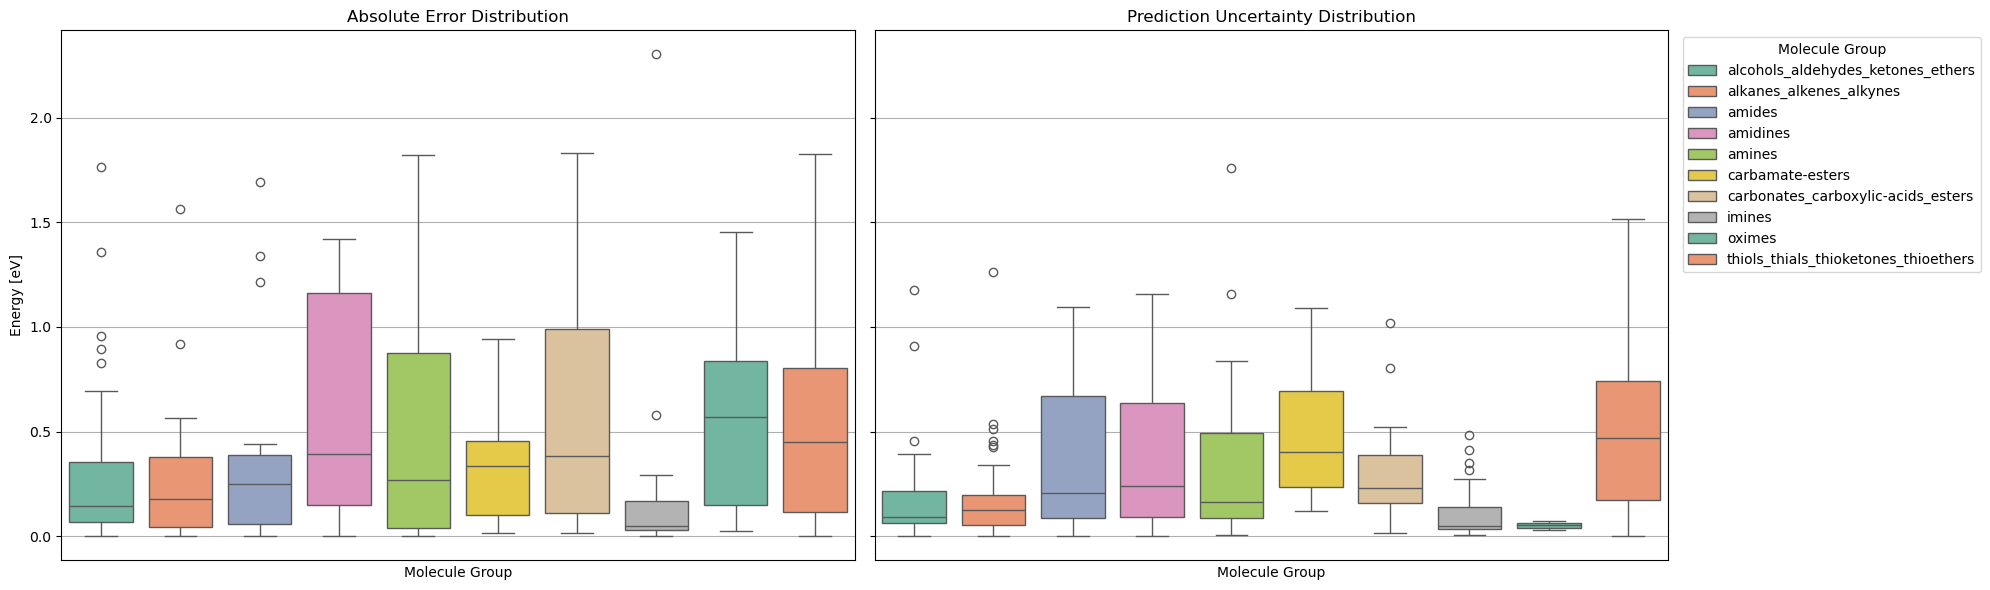

In [6]:
df_uq_sorted = df_uq[df_uq["split"] == "test"].sort_values('molecule_group')

df_uq_sorted['abs_error'] = df_uq_sorted['error'].abs()
df_uq_sorted['uncertainty_width'] = df_uq_sorted['y_std']

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# First subplot: Absolute Error
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='abs_error', hue='molecule_group', palette="Set2", legend=False, ax=axes[0])
axes[0].set_xlabel('Molecule Group')
axes[0].set_ylabel('Energy [eV]')
axes[0].set_title('Absolute Error Distribution')
axes[0].set_xticks([])
axes[0].grid(True)

# Second subplot: Uncertainty Width
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette="Set2", legend=True, ax=axes[1])
axes[1].set_xlabel('Molecule Group')
axes[1].set_ylabel('')  # Shared y-label already on left
axes[1].set_title('Prediction Uncertainty Distribution')
axes[1].set_xticks([])
axes[1].grid(True)
axes[1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


## Uncertainty Qualification per Surface

In [7]:
df_uq.groupby('material')['y_std'].mean()

material
IrO2    0.457252
RuO2    0.304437
Name: y_std, dtype: float64

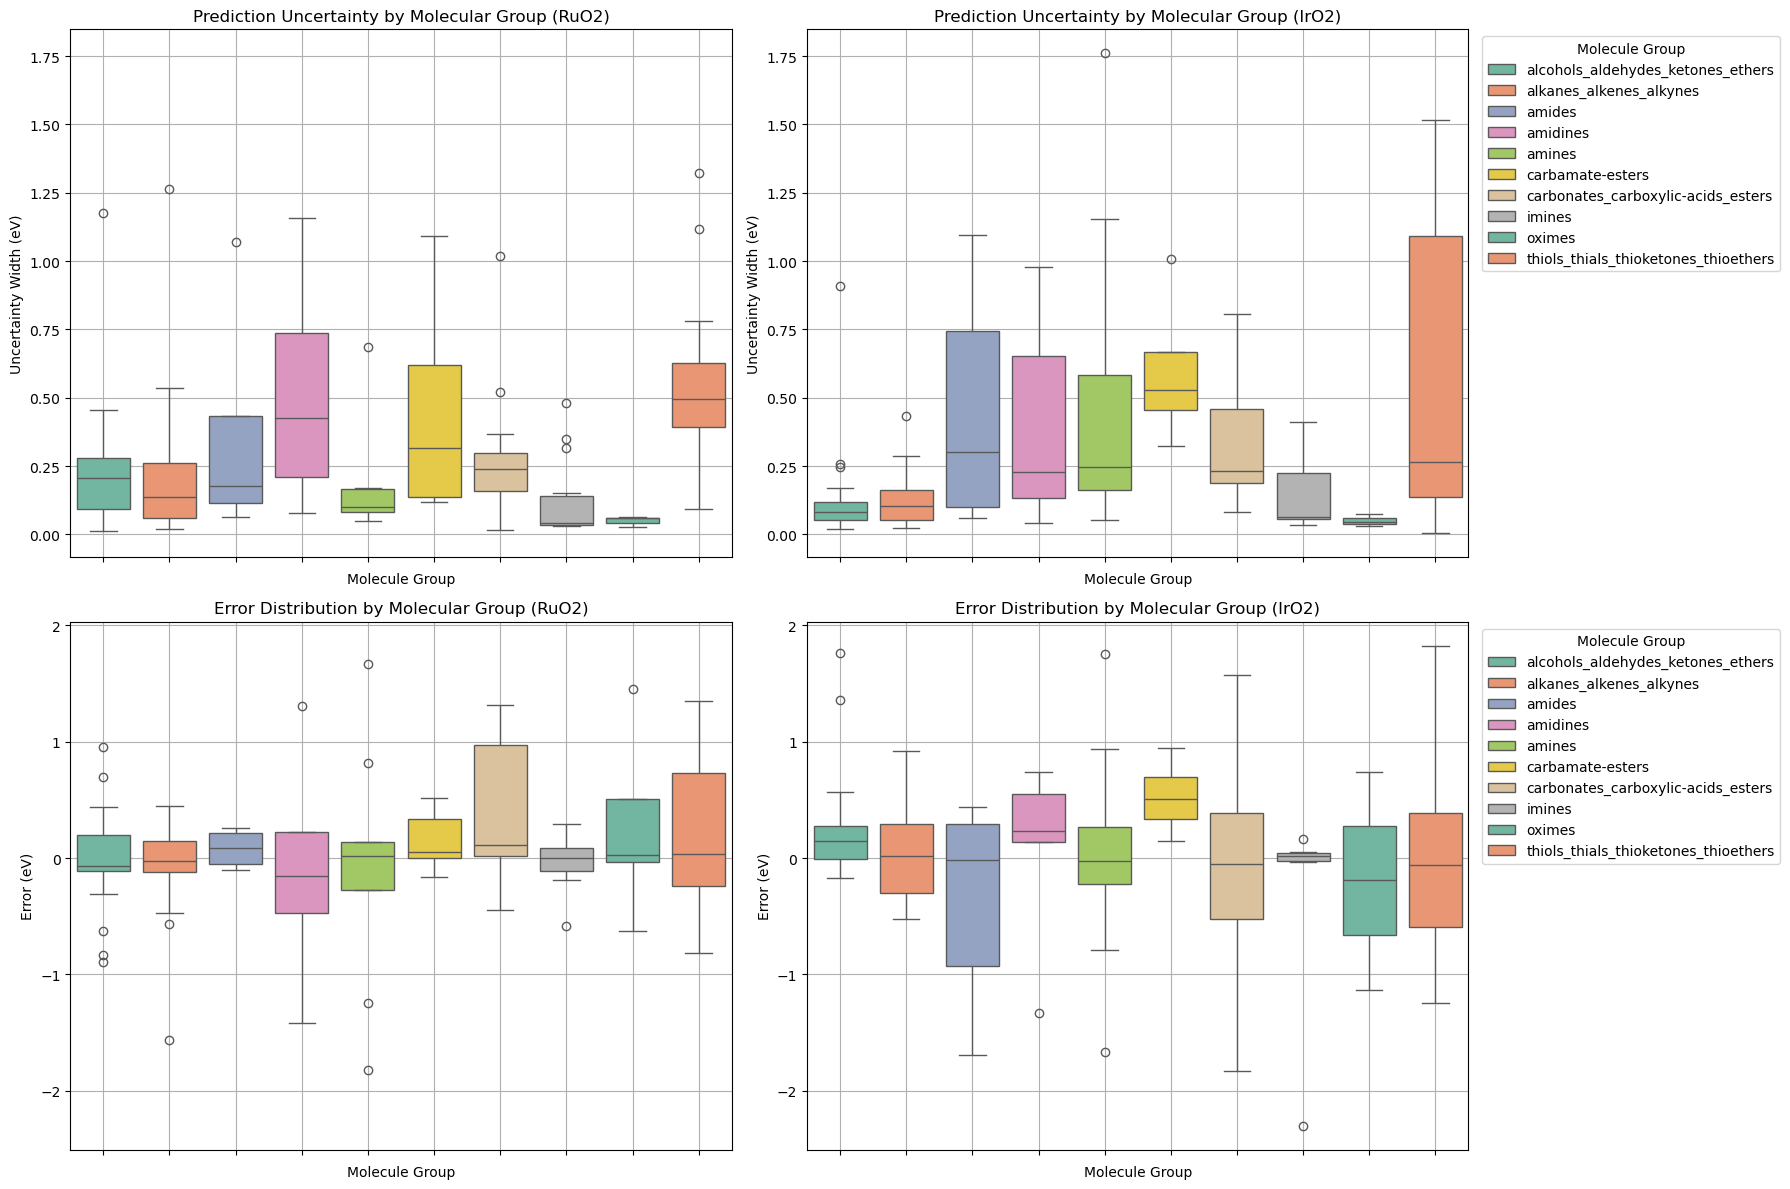

In [8]:
# Filter per material
df_ru = df_uq_sorted[df_uq_sorted['material'] == 'RuO2']
df_ir = df_uq_sorted[df_uq_sorted['material'] == 'IrO2']


# Create figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 1 row, 2 columns

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=False, ax=axes[0,0]
)
axes[0,0].set_title("Prediction Uncertainty by Molecular Group (RuO2)")
axes[0,0].set_xlabel("Molecule Group")
axes[0,0].set_ylabel("Uncertainty Width (eV)")
axes[0,0].set_xticklabels([])
axes[0,0].grid(True)
axes[0,0].sharey(axes[0,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=True, ax=axes[0,1])
axes[0,1].set_title("Prediction Uncertainty by Molecular Group (IrO2)")
axes[0,1].set_xlabel("Molecule Group")
axes[0,1].set_ylabel("Uncertainty Width (eV)")
axes[0,1].set_xticklabels([])
axes[0,1].grid(True)
axes[0,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=False, ax=axes[1,0]
)
axes[1,0].set_title("Error Distribution by Molecular Group (RuO2)")
axes[1,0].set_xlabel("Molecule Group")
axes[1,0].set_ylabel("Error (eV)")
axes[1,0].set_xticklabels([])
axes[1,0].grid(True)
axes[1,0].sharey(axes[1,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=True, ax=axes[1,1])
axes[1,1].set_title("Error Distribution by Molecular Group (IrO2)")
axes[1,1].set_xlabel("Molecule Group")
axes[1,1].set_ylabel("Error (eV)")
axes[1,1].set_xticklabels([])
axes[1,1].grid(True)
axes[1,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')



plt.tight_layout()
plt.show()


In [9]:
df_uq.sort_values(["y_true"], ascending=True).head(15)

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,norm_res
456,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,initial,-4.457949,-4.431297,0.063178,-4.555126,-4.307468,True,-0.026651,train,-0.421847
1148,C2H6Ir40N2O80,IrO2,110.0,amidines,Acetimidamide,relaxed,-4.457949,-4.598038,0.043250,-4.682808,-4.513267,False,0.140089,test,3.239036
436,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,initial,-4.369982,-2.515732,1.452431,-5.362496,0.331033,True,-1.854250,train,-1.276653
1184,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,initial,-4.367753,-3.037273,0.651221,-4.313667,-1.760879,False,-1.330480,test,-2.043053
237,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,relaxed,-4.367753,-4.337344,0.065674,-4.466064,-4.208624,True,-0.030409,train,-0.463030
323,C2H5Ir40NO81,IrO2,110.0,amides,Acetamide,initial,-3.725091,-1.601867,2.246579,-6.005161,2.801427,True,-2.123223,train,-0.945092
1033,C2H5Ir40NO81,IrO2,110.0,amides,Acetamide,relaxed,-3.725091,-3.714483,0.059554,-3.831210,-3.597757,True,-0.010607,test,-0.178114
349,CH3Ir40NO81,IrO2,110.0,amides,Formamide,initial,-3.628545,-1.725074,1.728780,-5.113482,1.663335,True,-1.903472,train,-1.101049
1180,CH3Ir40NO81,IrO2,110.0,amides,Formamide,initial,-3.628156,-1.935791,0.206771,-2.341063,-1.530520,False,-1.692364,test,-8.184724
786,CH3Ir40NO81,IrO2,110.0,amides,Formamide,initial,-3.627820,-0.805437,0.706657,-2.190484,0.579610,False,-2.822382,val,-3.993994


In [10]:
df_uq.sort_values(["y_std"], ascending=False).head(20)

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,norm_res
446,Ir40O80,IrO2,110.0,NaN,NaN,relaxed,0.000000,-1.576510,13.604244,-28.240830,25.087810,True,1.576510,train,0.115884
805,Ir40O80,IrO2,110.0,NaN,NaN,initial,0.000000,-1.576510,13.604244,-28.240830,25.087810,True,1.576510,val,0.115884
1098,O80Ru40,RuO2,110.0,NaN,NaN,initial,0.000000,-1.285929,12.889137,-26.548637,23.976780,True,1.285929,test,0.099768
373,O80Ru40,RuO2,110.0,NaN,NaN,relaxed,0.000000,-1.285929,12.889137,-26.548637,23.976780,True,1.285929,train,0.099768
729,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,initial,-3.474465,-2.040575,2.950913,-7.824366,3.743215,True,-1.433890,train,-0.485914
308,C3H8Ir40O80,IrO2,110.0,alkanes_alkenes_alkynes,Propane,initial,-0.418149,-2.939005,2.914226,-8.650888,2.772878,True,2.520857,train,0.865018
161,CH3Ir40NO82,IrO2,110.0,carbamate-esters,Carbamic-acid,initial,-3.436062,-1.618338,2.510845,-6.539596,3.302919,True,-1.817724,train,-0.723949
171,C3H9Ir40NO80,IrO2,110.0,amines,Propan-2-amine,initial,-2.129158,-1.826331,2.364966,-6.461665,2.809003,True,-0.302827,train,-0.128047
139,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-3.142078,-1.357584,2.331925,-5.928157,3.212989,True,-1.784494,train,-0.765245
828,C3H9Ir40NO80,IrO2,110.0,amines,Trimethylamine,initial,-0.816608,-1.026666,2.315285,-5.564623,3.511292,True,0.210057,val,0.090726


In [11]:
df_uq.sort_values(["error"], ascending=False).head(15)

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,norm_res
308,C3H8Ir40O80,IrO2,110.0,alkanes_alkenes_alkynes,Propane,initial,-0.418149,-2.939005,2.914226,-8.650888,2.772878,True,2.520857,train,0.865018
778,C3H9Ir40NO80,IrO2,110.0,amines,Propan-2-amine,initial,-0.474136,-2.836555,1.389863,-5.560687,-0.112423,True,2.362419,val,1.699749
438,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,initial,-0.211618,-2.430677,1.285777,-4.950801,0.089446,True,2.219060,train,1.725851
129,C3H9Ir40NO80,IrO2,110.0,amines,Propan-2-amine,initial,-0.527265,-2.564648,0.809159,-4.150600,-0.978696,False,2.037383,train,2.517901
276,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,relaxed,-0.363963,-2.379251,1.501117,-5.321441,0.562939,True,2.015288,train,1.342525
134,C3H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thione,relaxed,-0.321018,-2.315654,1.243173,-4.752274,0.120965,True,1.994636,train,1.604472
797,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Dimethylsulfane,initial,-0.304123,-2.220912,0.157748,-2.530098,-1.911727,False,1.916789,val,12.150970
514,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,initial,-0.363963,-2.221728,1.634155,-5.424671,0.981215,True,1.857765,train,1.136836
418,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Dimethylsulfane,relaxed,-0.304123,-2.138422,0.767883,-3.643473,-0.633372,False,1.834300,train,2.388775
1139,CH2Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethial,initial,-0.857223,-2.681451,0.138476,-2.952865,-2.410038,False,1.824228,test,13.173577


In [12]:
outliers = df_uq[df_uq["formula"] == "CH4Ir40O80S"]
outliers

,formula,material,surface,molecule_group,molecule,state,y_true,y_mean,y_std,y_min,y_max,in_interval,error,split,norm_res
139,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-3.142078,-1.357584,2.331925,-5.928157,3.212989,True,-1.784494,train,-0.765245
180,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-2.470673,-2.342923,0.671332,-3.658733,-1.027113,True,-0.127750,train,-0.190293
205,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-3.142078,-3.132762,0.094305,-3.317599,-2.947926,True,-0.009315,train,-0.098781
497,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-3.143192,-2.342923,0.671332,-3.658733,-1.027113,True,-0.800269,train,-1.192062
587,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-2.470673,-2.342923,0.671332,-3.658733,-1.027113,True,-0.127750,train,-0.190293
624,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-3.070039,-3.132762,0.094305,-3.317599,-2.947925,True,0.062723,train,0.665115
731,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-2.486884,-2.342923,0.671332,-3.658733,-1.027113,True,-0.143961,val,-0.214442
744,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,relaxed,-0.321731,-1.676149,1.611363,-4.834422,1.482123,True,1.354418,val,0.840542
870,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-0.321731,-0.889504,1.161008,-3.165080,1.386072,True,0.567773,val,0.489035
874,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,initial,-2.486884,-2.085457,0.996092,-4.037796,-0.133118,True,-0.401427,val,-0.403002


In [13]:
df_test_set[((df_test_set["Molecule Group"] == "thiols_thials_thioketones_thioethers") & (df_test_set["Material"] == "IrO2"))].sort_values("Molecule")

,System,Material,Surface,Molecule Group,Molecule,State,True_eV,Prediction_eV,Error_eV,Abs_error_eV
64,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,-2.502474,-2.708306,-0.205832,0.205832
86,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,-2.866476,-2.708306,0.158170,0.158170
220,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,-2.083250,-2.511427,-0.428177,0.428177
152,C2H4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethial,initial,-0.421980,-1.362864,-0.940884,0.940884
89,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,initial,-3.521611,-2.799144,0.722468,0.722468
129,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,initial,-2.404696,-2.403130,0.001566,0.001566
193,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,initial,-3.199007,-2.552839,0.646169,0.646169
183,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,relaxed,-3.389266,-3.326517,0.062749,0.062749
166,CH2Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethial,initial,-0.857223,-2.681451,-1.824228,1.824228
221,CH2Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethial,relaxed,-2.636059,-2.715069,-0.079010,0.079010
